## Simple DNN to mimic StIC inversions 

In [1]:
# Initial imports

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary #https://github.com/sksq96/pytorch-summary
torch.manual_seed(1234)
np.random.seed(1234)
from torch.utils.data import Subset

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
# We are going to make a dense autoencoder here:
# this time with convolutional layers


class testdnn(nn.Module):
    def __init__(self, inputsize, outputsize):
        super(testdnn, self).__init__()

        # Debug ones 
        self.lineardbg1 = nn.Linear(inputsize, 128)
        self.lineardbg2 = nn.Linear(128,32)
        
        self.linear0 = nn.Linear(136,32)
        self.linear1 = nn.Linear(32,16)
        self.linear1a = nn.Linear(16,16)
        self.linear2 = nn.Linear(16,16)
        self.linear2a = nn.Linear(16,8)
        self.linear3 = nn.Linear(8,8)
        self.linear4 = nn.Linear(8,16)
        self.linear5 = nn.Linear(16,16)
        self.linear6 = nn.Linear(16,outputsize)

        self.conv1 = nn.Conv1d(2, 8, 5, padding = 'same')
        self.conv2 = nn.Conv1d(8, 8, 5, padding = 'same')

        self.pool5 = nn.MaxPool1d(11)
        self.pool3 = nn.MaxPool1d(5)

        self.flatten = nn.Flatten()
         
        self.activation = nn.ReLU()
        self.activationS = nn.Sigmoid()
        
        self.dropout05 = nn.Dropout(0.5)
        
        
    def forward(self, data_in):

        x = self.conv1(data_in)
        x = self.pool5(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.pool3(x)
        x = self.activation(x)

        x = self.flatten(x)

        x = self.linear0(x)
        x = self.activationS(x)
        x = self.linear1(x)
        x = self.activationS(x)
        x = self.linear6(x)
            
        return x
    
def make_model(cudaoption, inputsize, outputsize):
    
    model = testdnn(inputsize, outputsize)
    
    if (cudaoption):
        print('[INFO] Cuda model:',torch.cuda.get_device_name(0))
        model = model.to(device)
        
        print('[INFO] Parameters in GPU:',next(model.parameters()).is_cuda) 
        
    return model   

def model_predict(model, inputdata, cudaoption):
    
    if cudaoption:
        
        model = model.to(device)
        inputdata = inputdata.to(device)
        
    output = model.forward(inputdata)
    
    output = output.to("cpu")
    return output

In [3]:
# test for GPU:

cudaoption = torch.cuda.is_available()
device = torch.device("cuda:0" if cudaoption else "cpu")
print('[INFO] Cuda:', cudaoption)
print('[INFO] Cuda device:', device)

[INFO] Cuda: True
[INFO] Cuda device: cuda:0


In [4]:
dnn_model = make_model(cudaoption, 967, 10)

[INFO] Cuda model: NVIDIA GeForce RTX 2060 with Max-Q Design
[INFO] Parameters in GPU: True


In [6]:
summary(dnn_model, (2, 967))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 8, 967]              88
         MaxPool1d-2                [-1, 8, 87]               0
              ReLU-3                [-1, 8, 87]               0
            Conv1d-4                [-1, 8, 87]             328
         MaxPool1d-5                [-1, 8, 17]               0
              ReLU-6                [-1, 8, 17]               0
           Flatten-7                  [-1, 136]               0
            Linear-8                   [-1, 32]           4,384
           Sigmoid-9                   [-1, 32]               0
           Linear-10                   [-1, 16]             528
          Sigmoid-11                   [-1, 16]               0
           Linear-12                   [-1, 10]             170
Total params: 5,498
Trainable params: 5,498
Non-trainable params: 0
-----------------------------------

In [7]:
def compilefit(model, data_in, data_out, data_val_in, data_val_out, nepochs, criterion, cudaoption, lri, output_interval, batch, weight_decayi, w):
    
    optimizer = torch.optim.Adam(model.parameters(), lr = lri, weight_decay = weight_decayi)
    loss_fn = nn.MSELoss()
    loss_val_fn = nn.MSELoss()
    
    if cudaoption:
        data_in = data_in.to(device)
        data_out = data_out.to(device)
        data_val_in = data_val_in.to(device)
        data_val_out = data_val_out.to(device)
        
       # w = w.to(device)
        
        
    performance = np.zeros([2,nepochs])
                
    for i in range(0,nepochs):
            
        optimizer.zero_grad()
        out = model.forward(data_in)
        loss = loss_fn(data_out, out)
        loss.backward()
        optimizer.step()
        performance[0,i] = loss.item()
        
        # Validation:
        out_val = model.forward(data_val_in)
        loss_val = loss_val_fn(out_val, data_val_out)
        performance[1,i] = loss_val.item()
        
            
        if (i+1)%int(output_interval)==0: print(f' It : {i+1:3d} - residual std : {np.sqrt(loss.item()):.6f} - val std : {np.sqrt(loss_val.item()):.6f}')
    return performance

### Ok, creating the model and making sure GPU works is done, now let's see what happens with data.

In [8]:
from astropy.io import fits 
import numpy as np
import matplotlib.pyplot as plt 

In [9]:
data_out = fits.open("full_training_set_out.fits")
data_out.info()

Filename: full_training_set_out.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   (200, 200, 4)   float32   
  1                1 ImageHDU         7   (200, 200)   float32   
  2                1 ImageHDU         8   (200, 200, 3)   float32   
  3                1 ImageHDU         8   (200, 200, 2)   float32   
  4                1 ImageHDU         7   (200, 200)   float32   


In [10]:
data_in = fits.open("full_training_set_in.fits")

In [11]:
stokes = data_in[0].data
stokes.shape

(200, 200, 2, 967)

In [12]:
data_in = stokes[:,:,:,:]
data_in = data_in.reshape(200*200, 2,967)

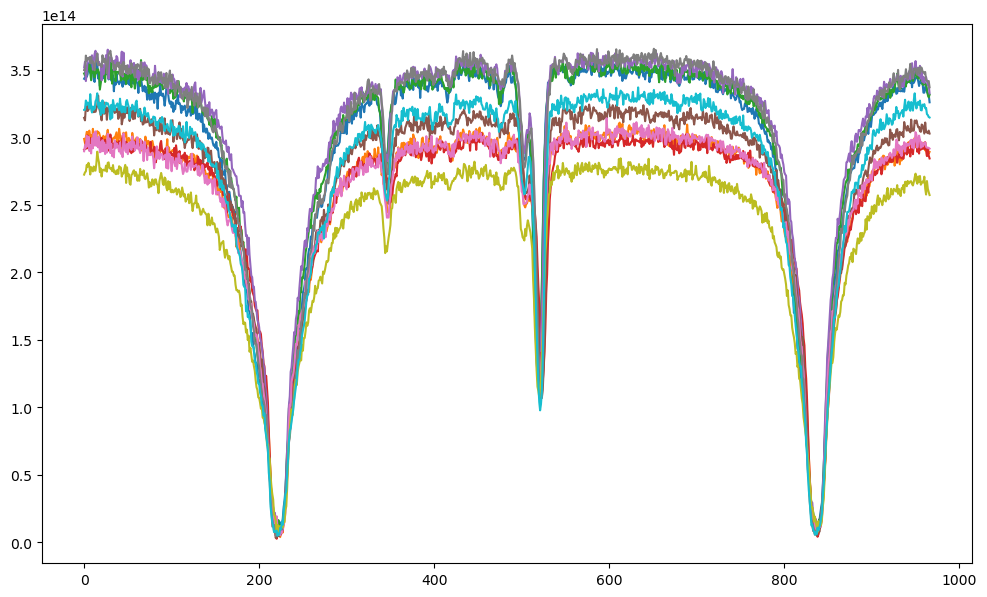

In [13]:
plt.figure(figsize=[12,7])
for i in range(0,10):
    plt.plot(data_in[i*100][0])

In [14]:
data_in_norm = np.copy(data_in)

In [15]:
# Let's try with a normalization w.r.t. line core:
#mean_spectrum = np.mean(data_in_norm[:,0,:],axis=(0))
#w = np.sqrt(mean_spectrum)
#w = torch.from_numpy(w.astype('float32'))
qs = np.mean(data_in_norm[:,0,500:700])
print("Qs = ", qs)
data_in_norm /= qs

w = 1.0

Qs =  298720819764540.94


In [16]:
dimax = np.amax(data_in_norm[:,0,:])
dimin = np.amin(data_in_norm[:,0,:])

print (dimax, dimin)


1.5449949542926933 -0.007779985706232224


In [17]:
data_in_norm[:,0,:] = (data_in_norm[:,0,:] - dimin) / (dimax - dimin)

In [18]:
#data_in_norm[:,1,:] *= 3 # hits it around 1

In [19]:
print (np.max(data_in_norm[:,1,:]))
print (np.min(data_in_norm[:,1,:]))

0.3336975317126042
-0.3289580416425976


In [20]:
dimax = np.amax(data_in_norm[:,1,:])
dimin = np.amin(data_in_norm[:,1,:])
data_in_norm[:,1,:] = (data_in_norm[:,1,:] - dimin) / (dimax - dimin)

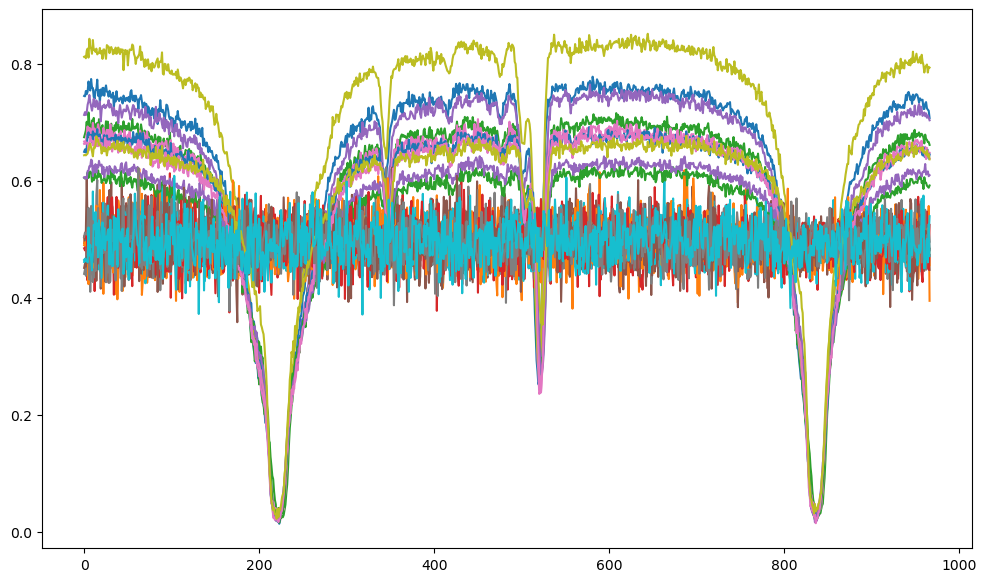

In [21]:
plt.figure(figsize=[12,7])
for i in range(0,10):
    plt.plot(data_in_norm[i*1000, 0])
    plt.plot(data_in_norm[i*1000, 1])

In [22]:
kek = data_in_norm[:,:,:].reshape(40000,2,967)
data_in_norm = torch.from_numpy(kek.astype('float32'))
data_in_norm.shape


torch.Size([40000, 2, 967])

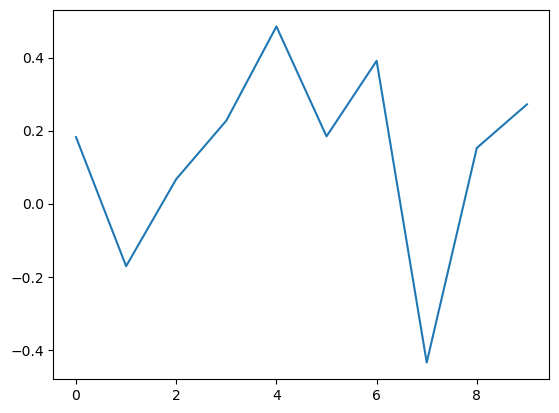

In [23]:
test_output = model_predict(dnn_model,data_in_norm[:10],cudaoption)
test_output.shape
plt.plot(test_output[0].detach().numpy())

### Normalize the output data:

In [24]:
data_out = fits.open("full_training_set_out.fits")

In [25]:
temp = data_out[0].data
vturb = data_out[1].data
vlos = data_out[2].data
B = data_out[3].data
theta = data_out[4].data

B *= np.cos(theta[None,:,:])


# Normalizations:
max_t = np.amax(temp)
min_t = np.amin(temp)
max_vlos = np.amax(vlos)
min_vlos = np.amin(vlos)
max_vturb = np.amax(vturb)
min_vturb = np.amin(vturb)
max_b = np.amax(B)
min_b = np.amin(B)
theta = np.cos(theta)
theta = (theta + 1.0) * 0.5


In [26]:
print (temp.shape)
print (vturb.shape)
print (vlos.shape)
print (B.shape)
print (theta.shape)


(4, 200, 200)
(200, 200)
(3, 200, 200)
(2, 200, 200)
(200, 200)


In [27]:
print(min_t,max_t)
print(min_vlos/1E5, max_vlos/1E5)
print(min_vturb/1E5, max_vturb/1E5)
print(min_b, max_b)

3400.0 7313.5137
-8.538841875 6.511476875
0.001 4.2086578125
-3724.922 2050.424


In [28]:
NX = 200
NY = 200
NP = 11

In [29]:
temp_norm = (temp-min_t) / (max_t - min_t)
vlos_norm = (vlos-min_vlos) / (max_vlos - min_vlos)
vturb_norm = (vturb-min_vturb) / (max_vturb - min_vturb)
b_norm = (B - min_b) / (max_b - min_b)

In [30]:
data_out_norm = np.concatenate((temp_norm[:,:,:], vturb_norm[None,:,:], vlos_norm[:,:,:], b_norm[:,:,:]),axis=0)
#data_out_norm = np.concatenate((temp_norm[:,:,:], vturb_norm[None,:,:], vlos_norm[:,:,:]),axis=0)
NP = 10
data_out_norm = data_out_norm.reshape(NP, NX*NY)
data_out_norm = data_out_norm.T
data_out_norm.shape

(40000, 10)

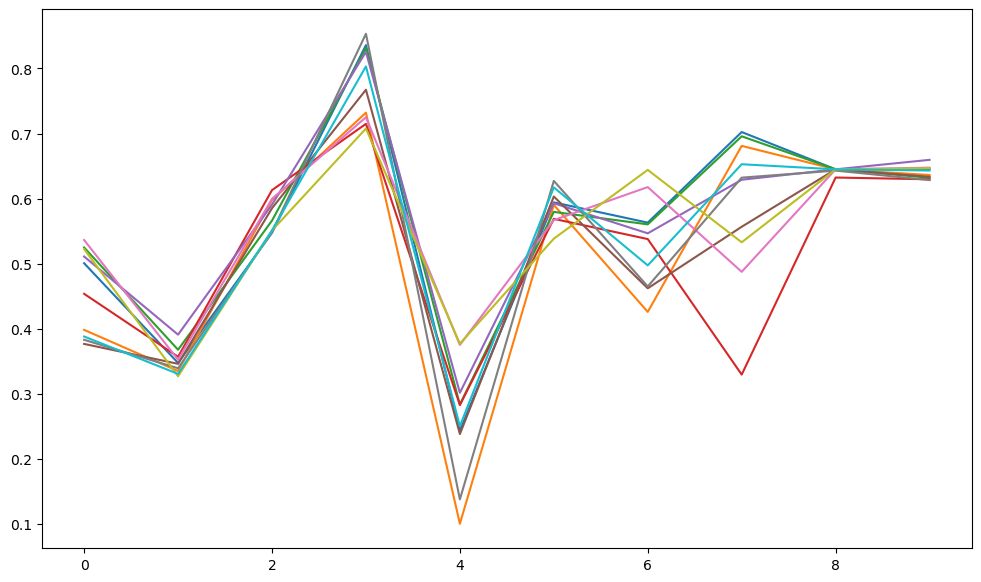

In [31]:
plt.figure(figsize=[12,7])
for i in range(0,10):
    plt.plot(data_out_norm[i*100])

In [45]:
data_out_norm = torch.from_numpy(data_out_norm.astype('float32'))

In [47]:
convergence = compilefit(dnn_model, data_in_norm, data_out_norm, data_in_norm, data_out_norm, \
                         1000, 0, cudaoption, 5E-4, 20, 100, 0, 1.0)

 It :  20 - residual std : 0.050219 - val std : 0.050195
 It :  40 - residual std : 0.050082 - val std : 0.050080
 It :  60 - residual std : 0.049992 - val std : 0.049987
 It :  80 - residual std : 0.049907 - val std : 0.049903
 It : 100 - residual std : 0.049818 - val std : 0.049813
 It : 120 - residual std : 0.049721 - val std : 0.049716
 It : 140 - residual std : 0.049619 - val std : 0.049614
 It : 160 - residual std : 0.049512 - val std : 0.049507
 It : 180 - residual std : 0.049401 - val std : 0.049395
 It : 200 - residual std : 0.049286 - val std : 0.049280
 It : 220 - residual std : 0.049169 - val std : 0.049163
 It : 240 - residual std : 0.049048 - val std : 0.049042
 It : 260 - residual std : 0.048925 - val std : 0.048919
 It : 280 - residual std : 0.048800 - val std : 0.048794
 It : 300 - residual std : 0.048673 - val std : 0.048667
 It : 320 - residual std : 0.048544 - val std : 0.048537
 It : 340 - residual std : 0.048412 - val std : 0.048406
 It : 360 - residual std : 0.04

In [48]:
torch.save(dnn_model, 'sstinv_full_take_2.pt')

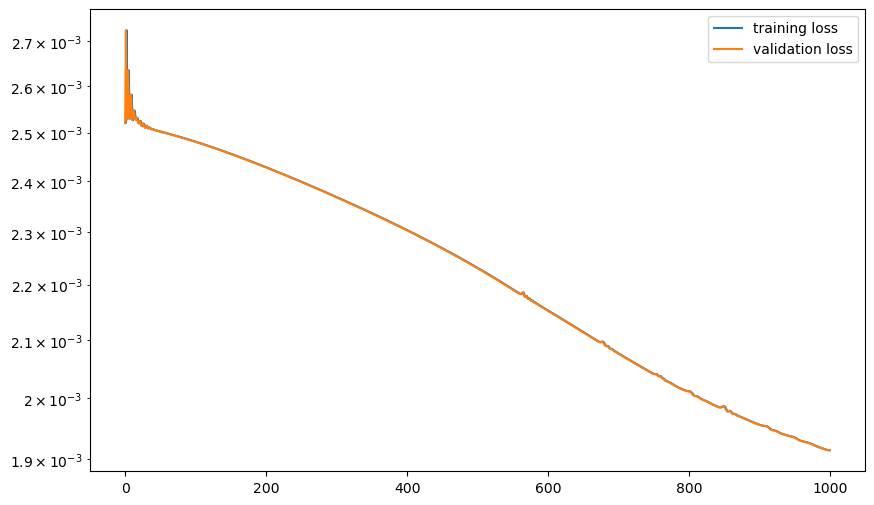

In [49]:
plt.figure(figsize=[10,6])
plt.semilogy(convergence[0],label='training loss') 
plt.semilogy(convergence[1], label = 'validation loss') 
plt.legend()

### Here we do some statistical analysis of the "compression"

In [50]:
test_output = model_predict(dnn_model,data_in_norm,cudaoption)

In [51]:
data_reconstructed = test_output.detach().numpy()

In [52]:
data_out_norm = data_out_norm.detach().numpy()

(200, 200)


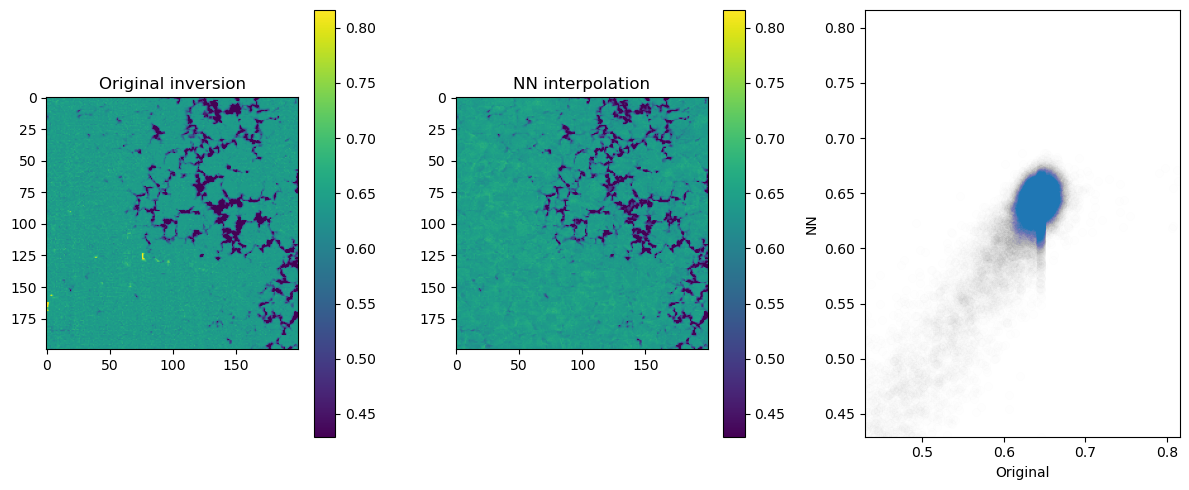

In [56]:
NX = 200
NY = 200
NP = 10
# Test some plots here:
i = 9
plt.figure(figsize=[12,5])

plt.subplot(131)
temp = data_out_norm.reshape(NX,NY,NP)[:,:,i]
print(temp.shape)
v_min = np.mean(temp) - 3 * np.std(temp)
v_max = np.mean(temp) + 3 * np.std(temp)
plt.imshow(data_out_norm.reshape(NX, NY, NP)[:,:,i].T,vmin=v_min,vmax=v_max)
plt.title("Original inversion")
plt.colorbar()

plt.subplot(132)
plt.imshow(data_reconstructed.reshape(NX,NY,NP)[:,:,i].T,vmin=v_min,vmax=v_max)
plt.title("NN interpolation")
plt.colorbar()

plt.subplot(133)
plt.scatter(data_out_norm.reshape(NX,NY,NP)[:,:,i], data_reconstructed.reshape(NX,NY,NP)[:,:,i],alpha=0.002)
plt.xlim([v_min,v_max])
plt.ylim([v_min,v_max])
plt.xlabel("Original")
plt.ylabel("NN")
plt.tight_layout()

In [ ]:
print(np.std(data_out_norm.reshape(NX, NY, NP)[:,:,i] - data_reconstructed.reshape(NX, NY, NP)[:,:,i])*(max_t-min_t))